# Dynamic filter MNIST classification

Note: This notebook is designed to run with GPU runtime.

Import modules and set random seeds.

In [1]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

random.seed(20230515)
np.random.seed(20190825)
tf.random.set_seed(20190825)

plt.rcParams.update({'font.size': 10})

Download the MNIST dataset and store into NumPy arrays.

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                    (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                    (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Define the CNN model with a single convolutional filter layer.

In [3]:
model = models.Sequential(name='CNN_model')
model.add(layers.Input(shape=(784,), name='input'))
model.add(layers.Reshape((28, 28, 1), name='reshape'))
model.add(layers.Conv2D(16, (5, 5), padding='same', strides=2,
                        use_bias=True, activation='relu',
                        name='conv_filter'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(512, activation='relu', name='feedforward'))
model.add(layers.Dense(10, activation='softmax', name='softmax'))

model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter (Conv2D)                 │ (None, 14, 14, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward (Dense)                  │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,611,690 (6.15 MB)

 Trainable params: 1,611,690 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and the categorical crossentroy as a loss function.

In [4]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

Train the model. It achieves around 98 ~ 99% accuracy.

In [5]:
history = model.fit(train_images, train_labels,
                    validation_data=(test_images, test_labels),
                    batch_size=128, epochs=10)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - acc: 0.8819 - loss: 0.4215 - val_acc: 0.9749 - val_loss: 0.0789
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9773 - loss: 0.0753 - val_acc: 0.9792 - val_loss: 0.0597
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9853 - loss: 0.0458 - val_acc: 0.9832 - val_loss: 0.0499
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9917 - loss: 0.0288 - val_acc: 0.9830 - val_loss: 0.0544
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.9944 - loss: 0.0193 - val_acc: 0.9836 - val_loss: 0.0541
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.9959 - loss: 0.0139 - val_acc: 0.9858 - val_loss: 0.0501
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.9972 - loss: 0.0095 - val_acc: 0.9843 - val_loss: 0.0576
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.9976 - loss: 0.0084 - val_acc: 0.9848 - val_loss: 0.0528
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - ac

Plot charts for the accuracy and loss values.

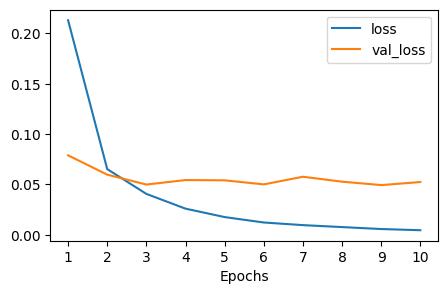

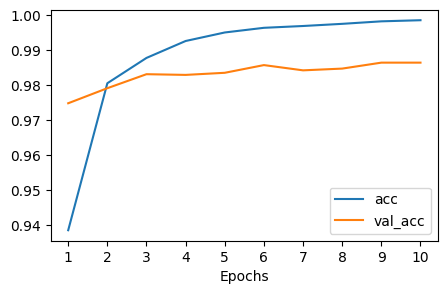

In [6]:
df = DataFrame({'loss': history.history['loss'],
                'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
                'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Apply the trained filters to the MNIST dataset.

In [7]:
model2 = models.Model(model.inputs,
                      model.get_layer('conv_filter').output,
                      name='conv_filter_output')
model2.summary()

Model: "conv_filter_output"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter (Conv2D)                 │ (None, 14, 14, 16)          │             416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 416 (1.62 KB)

 Trainable params: 416 (1.62 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
labels = [np.argmax(label) for label in test_labels]
sample_images = np.array([test_images[labels.index(i)] for i in range(10)])
conv_output = model2.predict(sample_images, verbose=0)

filter_vals = model.get_layer('conv_filter').get_weights()[0]

Show images after applying the convolutional filters.

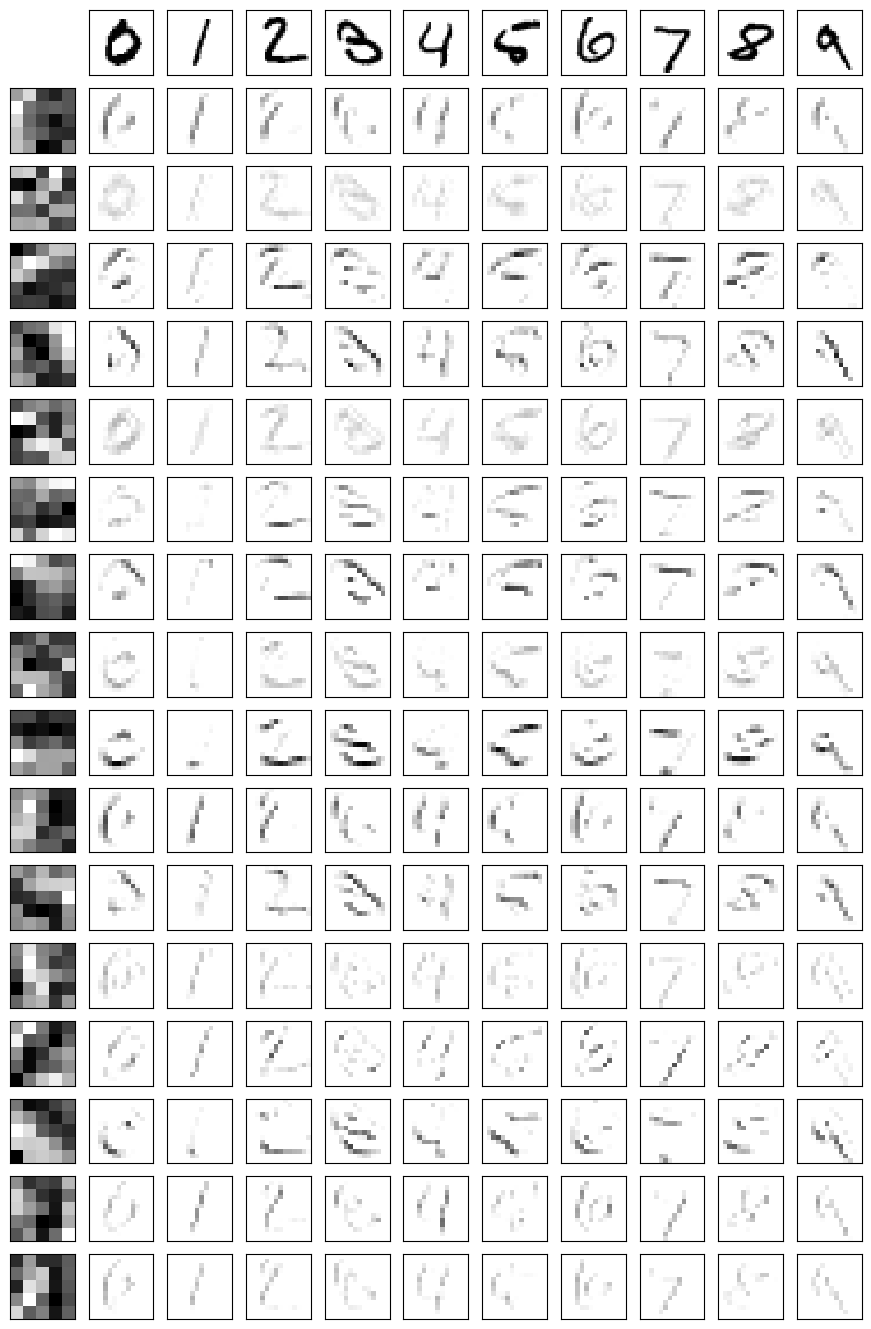

In [9]:
num_filters = filter_vals.shape[-1]
fig = plt.figure(figsize=(11, num_filters+1))
v_max = np.max(conv_output)

for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 11, 11*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], interpolation='none',
                   cmap=plt.cm.gray_r)

for i in range(10):
    subplot = fig.add_subplot(num_filters+1, 11, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(sample_images[i].reshape((28, 28)), interpolation='none',
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 11, 11*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv_output[i, :, :, f], interpolation='none',
                       vmin=0, vmax=v_max, cmap=plt.cm.gray_r)